In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import re
from fme.ace.data_loading.perturbation import (
    ConstantConfig,
    GreensFunctionConfig,
    PerturbationSelector,
)
from pathlib import Path
import torch
from scipy.stats import pearsonr
import cmocean
import matplotlib.ticker as ticker
plt.rcParams['font.size'] = 12

In [ ]:
patch_names_e3sm = ["F2010.40yr.140.0E_0.0N_2K", "F2010.40yr.260.0E_n20.0N_2K", "F2010.40yr.180.0E_40.0N_2K"]
patch_names_ace = ["sst_patch_140.0E_0.0N_2K_anomaly", "sst_patch_260.0E_-20.0N_2K_anomaly", "sst_patch_180.0E_40.0N_2K_anomaly"]
patch_names = ["Tropical_ascent_40yr", "Tropical_subsidence", "Extratropical"]
e3sm_patches = {}
ace_patches = {}
e3sm_patches_global_R = {}
ace_patches_global_R = {}

In [5]:
def get_ace_sst_perturbation(config, ocean_fraction, lat, lon):
    selector = PerturbationSelector(
        type="greens_function",
        config=config,
    )
    perturbation = selector.build()
    lats, lons = torch.meshgrid(torch.from_numpy(lat), torch.from_numpy(lon), indexing="ij")
    nx, ny = len(lat), len(lon)
    ocean_fraction = torch.from_numpy(ocean_fraction)
    data = torch.zeros(nx, ny, device="cpu")
    perturbation.apply_perturbation(data, lats.to("cpu"), lons.to("cpu"), ocean_fraction)
    return data.data.numpy()

In [ ]:
forcing = xr.open_dataset("/pscratch/sd/e/elynnwu/e3smv3-fme-data/gfmip-annual-repeating-sst-sic/1971.nc")
forcing = forcing.sel(time=slice("1971-01-01", "1981-01-01"))
ocean_fraction = forcing.OCNFRAC.mean(dim="time").values
lat = forcing.lat.values
lon = forcing.lon.values
pattern = r"[-+]?\d*\.\d+|[-+]?\d+"
SST_anom = {}
for i in range(len(patch_names_ace)):
    info = re.findall(pattern, patch_names_ace[i])
    amplitude = float(info[-1])
    lat_center = float(info[1])
    lon_center = float(info[0])
    config={
                "amplitude": amplitude,
                "lat_center": lat_center,
                "lon_center": lon_center,
                "lat_width": 20.0,
                "lon_width": 80.0,
            }
    SST_anom[patch_names[i]] = get_ace_sst_perturbation(config, ocean_fraction, lat, lon)

In [8]:
i = 0
for patch in patch_names:
    e3sm_patches[patch] = xr.open_dataset(f"/pscratch/sd/e/elynnwu/EAMv3-data/e3smv3-greens-experiment/{patch_names_e3sm[i]}.nc")
    ace_patches[patch] = xr.open_dataset(f"/pscratch/sd/e/elynnwu/fme-output/greens-experiment-v3/beaker-RS4/{patch_names_ace[i]}/monthly_mean_predictions.nc")
    i += 1

In [ ]:
i = 0
for patch in patch_names:
    area_weights = np.cos(np.deg2rad(e3sm_patches[patch].lat))
    toa_R = e3sm_patches[patch]["FSNT"] - e3sm_patches[patch]["FLNT"]
    e3sm_patches_global_R[patch] = toa_R.weighted(area_weights).mean(("lat", "lon"))
    area_weights = np.cos(np.deg2rad(ace_patches[patch].lat))
    ace_patches_global_R[patch] = ace_patches[patch]["net_energy_flux_toa_into_atmosphere"].weighted(area_weights).mean(("lat", "lon"))
    i += 1

In [11]:
e3sm_patches_time_mean_R = {}

In [12]:
i = 0
for patch in patch_names:
    toa_R = e3sm_patches[patch]["FSNT"] - e3sm_patches[patch]["FLNT"]
    e3sm_patches_time_mean_R[patch] = toa_R.mean("time")
    i += 1

In [13]:
ace_control = xr.open_dataset("/pscratch/sd/e/elynnwu/fme-output/greens-experiment-v3/beaker-RS4/control_run_40yr_v3/monthly_mean_predictions.nc")
e3sm_control = xr.open_dataset("/pscratch/sd/e/elynnwu/EAMv3-data/e3smv3-greens-experiment/F2010.control.gaussian.40yr.nc")

In [ ]:
toa_R = e3sm_control["FSNT"] - e3sm_control["FLNT"]
area_weights = np.cos(np.deg2rad(e3sm_control.lat))
e3sm_control_toa_R = toa_R.weighted(area_weights).mean(("lat", "lon"))

area_weights = np.cos(np.deg2rad(ace_control.lat))
ace_control_toa_R = ace_control["net_energy_flux_toa_into_atmosphere"].weighted(area_weights).mean(("lat", "lon"))

<xarray.DataArray ()> Size: 8B
array(0.85887558)
Coordinates:
    init_time  datetime64[ns] 8B 1971-01-01
<xarray.DataArray 'net_energy_flux_toa_into_atmosphere' ()> Size: 8B
array(-0.39881105)
Coordinates:
    init_time  datetime64[ns] 8B 1971-01-01
<xarray.DataArray 'net_energy_flux_toa_into_atmosphere' ()> Size: 8B
array(-0.03833974)
Coordinates:
    init_time  datetime64[ns] 8B 1971-01-01
<xarray.DataArray 'net_energy_flux_toa_into_atmosphere' ()> Size: 8B
array(-0.0753787)
Coordinates:
    init_time  datetime64[ns] 8B 1971-01-01


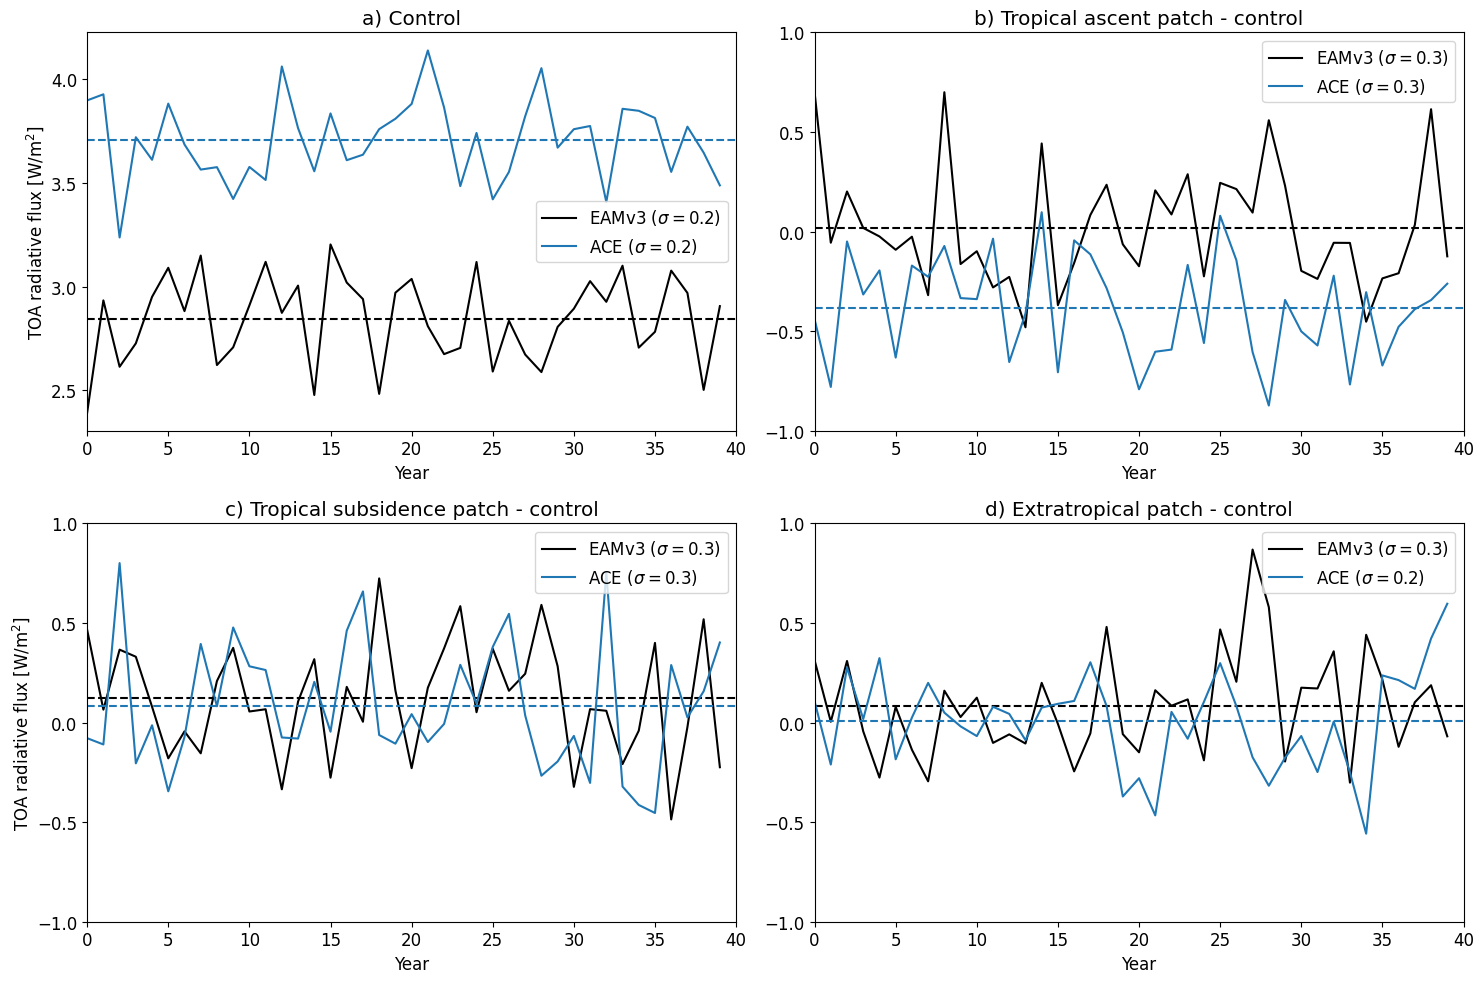

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
i = 0
e3sm_control_toa_R_annual = e3sm_control_toa_R.coarsen(time=12, boundary="trim").mean()
ace_control_toa_R_annual = ace_control_toa_R.sel(sample=0).coarsen(time=12, boundary="trim").mean()
axes[i].plot(e3sm_control_toa_R_annual, label=rf"EAMv3 ($\sigma=${e3sm_control_toa_R_annual.std().data.item():.1f})", color="k")
axes[i].plot([0, 40], [e3sm_control_toa_R_annual.mean(), e3sm_control_toa_R_annual.mean()], color="k", linestyle="--")
axes[i].plot(ace_control_toa_R_annual, label=rf"ACE ($\sigma=${ace_control_toa_R_annual.std().data.item():.1f})", color="tab:blue")
axes[i].plot([0, 40], [ace_control_toa_R_annual.mean(), ace_control_toa_R_annual.mean()], linestyle="--", color="tab:blue")
print(ace_control_toa_R_annual.mean() - e3sm_control_toa_R_annual.mean())
axes[i].set_title("a) Control")
axes[i].set_xlabel("Year")
axes[i].set_xlim([0, 40])
axes[i].set_yticks(np.arange(2.5, 4.5, 0.5))
axes[i].legend(loc=7)
axes[i].set_ylabel(r"TOA radiative flux [W/m$^2$]")
i += 1
titles = ["b) Tropical ascent", "c) Tropical subsidence", "d) Extratropical"]
for patch in patch_names[0:3]:
    e3sm = e3sm_patches_global_R[patch].coarsen(time=12, boundary="trim").mean().values - e3sm_control_toa_R_annual.values
    ace = ace_patches_global_R[patch].sel(sample=0).coarsen(time=12, boundary="trim").mean() - ace_control_toa_R_annual
    axes[i].plot(e3sm, label=rf"EAMv3 ($\sigma=${np.std(e3sm):.1f})", color="k")
    axes[i].plot([0, 40], [np.mean(e3sm), np.mean(e3sm)], color="k", linestyle="--")
    axes[i].plot(ace, label=rf"ACE ($\sigma=${ace.std().data.item():.1f})", color="tab:blue")
    axes[i].plot([0, 40], [ace.mean(), ace.mean()], linestyle="--", color="tab:blue")
    print(ace.mean() - np.mean(e3sm))
    axes[i].set_title(titles[i-1] + " patch - control")
    axes[i].set_xlabel("Year")
    axes[i].set_xlim([0, 40])
    axes[i].set_ylim([-1, 1])
    axes[i].set_yticks(np.arange(-1, 1.1, 0.5))
    axes[i].legend(loc=1)
    i += 1
axes[2].set_ylabel(r"TOA radiative flux [W/m$^2$]")
plt.tight_layout()
fig.patch.set_alpha(0.0)
fig.savefig(
    "e3smv3-80levs-RS4/2025-04-30-three-patches-time-series-of-TOA-beaker-RS4.png",
    dpi=200,  
    bbox_inches="tight",
)

In [16]:
VAR = "net_energy_flux_toa_into_atmosphere"
ace_control_toa_R_avg = ace_control[VAR].sel(sample=0).mean("time")
e3sm_control_toa_R_avg = e3sm_control["FSNT"].isel(time=slice(0, 240)).mean("time") - e3sm_control["FLNT"].isel(time=slice(0, 240)).mean("time")

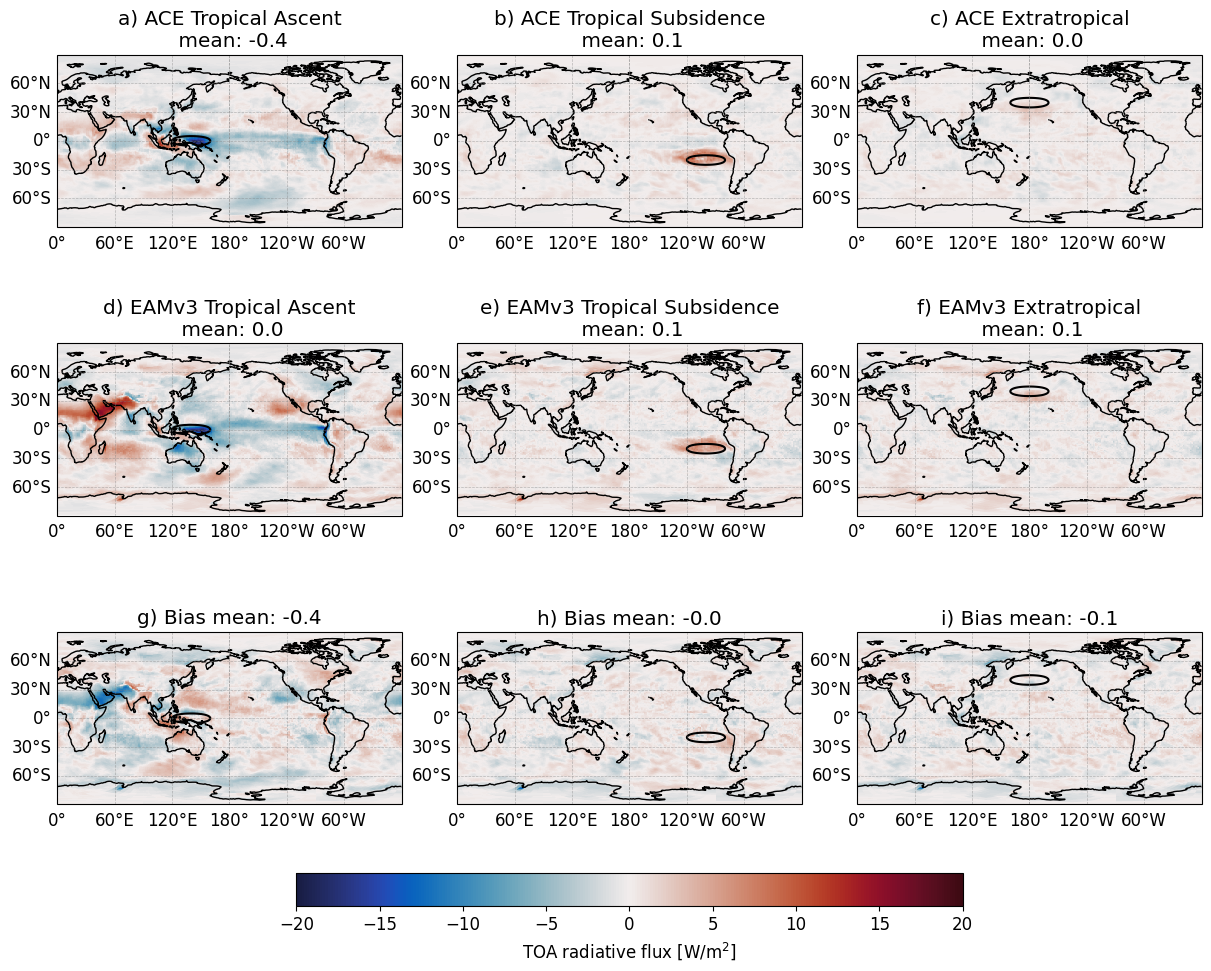

In [18]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
labels = ["a) ACE Tropical Ascent", "b) ACE Tropical Subsidence", "c) ACE Extratropical"]
labels_2 = ["d) EAMv3 Tropical Ascent", "e) EAMv3 Tropical Subsidence", "f) EAMv3 Extratropical"]
labels_3 = ["g) Bias", "h) Bias", "i) Bias"]
axes = axes.flatten()
lons, lats = np.meshgrid(ace_control["lon"], ace_control["lat"])
i = 0
for patch in patch_names[0:3]:
    toa_flux_diff_ace = ace_patches[patch][VAR].sel(sample=0).mean("time") - ace_control_toa_R_avg  
    cf = axes[i].pcolormesh(lons, lats, toa_flux_diff_ace, vmin=-20, vmax=20, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance)
    mean = toa_flux_diff_ace.weighted(np.cos(np.deg2rad(ace_control["lat"]))).mean(("lat", "lon"))
    axes[i].contour(lons, lats, SST_anom[patch.replace("_40yr", "")], transform=ccrs.PlateCarree(), cmap="binary_r", levels=[1])
    axes[i].coastlines()
    axes[i].set_global()
    axes[i].set_title(labels[i]+f"\n mean: {mean:.1f}")
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False

    toa_flux_diff_e3sm = e3sm_patches_time_mean_R[patch] - e3sm_control_toa_R_avg  
    cf = axes[i+3].pcolormesh(lons, lats, toa_flux_diff_e3sm, vmin=-20, vmax=20, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance)
    mean = toa_flux_diff_e3sm.weighted(np.cos(np.deg2rad(e3sm_control["lat"]))).mean(("lat", "lon"))
    axes[i+3].contour(lons, lats, SST_anom[patch.replace("_40yr", "")], transform=ccrs.PlateCarree(), cmap="binary_r", levels=[1])
    axes[i+3].coastlines()
    axes[i+3].set_global()
    axes[i+3].set_title(labels_2[i]+f"\n mean: {mean:.1f}")
    gl = axes[i+3].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False

    bias = toa_flux_diff_ace.values - toa_flux_diff_e3sm.values
    cf = axes[i+6].pcolormesh(lons, lats, bias, vmin=-20, vmax=20, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance)
    mean = np.average(bias, weights=np.cos(np.deg2rad(lats)))
    axes[i+6].contour(lons, lats, SST_anom[patch.replace("_40yr", "")], transform=ccrs.PlateCarree(), cmap="binary_r", levels=[1])
    axes[i+6].coastlines()
    axes[i+6].set_global()
    axes[i+6].set_title(f"{labels_3[i]} mean: {mean:.1f}")
    gl = axes[i+6].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    i += 1    

cbar = fig.colorbar(cf, ax=axes[:], orientation="horizontal", pad=0.05, fraction=0.04)
cbar.set_label(r"TOA radiative flux [W/m$^2$]")

fig.patch.set_alpha(0.0)
fig.set_constrained_layout(True)
fig.savefig(
    "e3smv3-80levs-RS4/2025-04-30-40yr-3patches-TOA-radiation-beaker-RS4-cm-balance.png",
    dpi=200,  
    bbox_inches="tight",
)

### Figures for ACE-EAMv3 AMIP evaluation

In [29]:
path = "/pscratch/sd/e/elynnwu/fme-output/greens-experiment-v3/beaker-RS2/amip-1970-2020/"
annual = xr.open_dataset(path+"annual_diagnostics.nc")
time_mean = xr.open_dataset(path+"time_mean_diagnostics.nc")

ACE mean: 3.9920854568481445, std: 0.6028835773468018
E3SM mean: 2.85068416595459, std: 0.7889583706855774
ACE mean: 238.0281524658203, std: 0.41424673795700073
E3SM mean: 238.24464416503906, std: 0.6290023326873779
ACE mean: 98.24007415771484, std: 0.30266207456588745
E3SM mean: 99.1649169921875, std: 0.3128955662250519


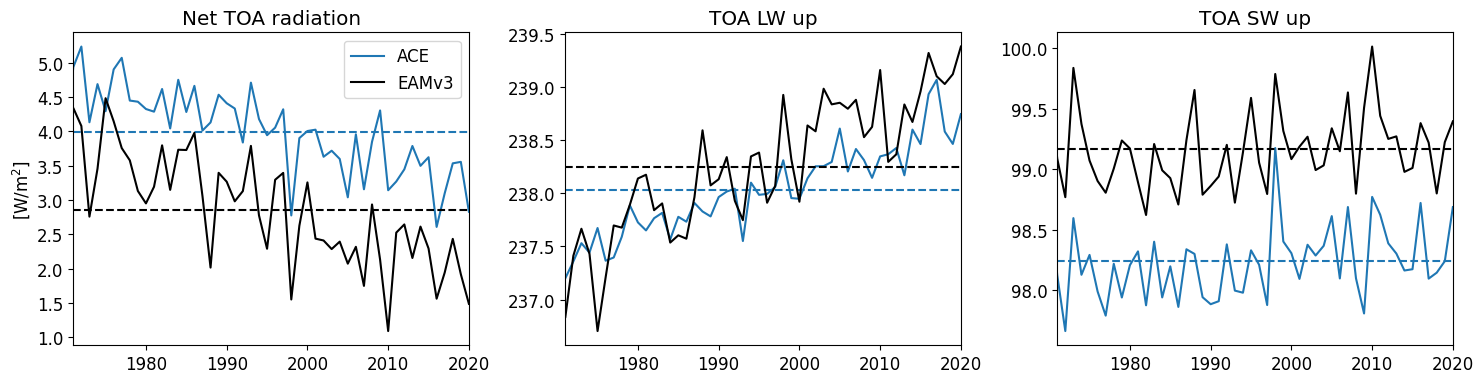

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.flatten()
i = 0
titles = ["Net TOA radiation", "TOA LW up", "TOA SW up"]
for var in ["net_energy_flux_toa_into_atmosphere", "FLUT", "top_of_atmos_upward_shortwave_flux"]:
    axes[i].plot(annual.year, annual[var].sel(source="prediction", sample=0), label="ACE")
    mean = annual[var].sel(source="prediction", sample=0).mean()
    std = annual[var].sel(source="prediction", sample=0).std()
    print(f"ACE mean: {mean.values}, std: {std.values}")
    axes[i].plot([1971, 2020], [mean, mean], linestyle="--", color="tab:blue")
    axes[i].plot(annual.year, annual[var].sel(source="target", sample=0), label="EAMv3", color="k")
    mean = annual[var].sel(source="target", sample=0).mean()
    std = annual[var].sel(source="target", sample=0).std()
    print(f"E3SM mean: {mean.values}, std: {std.values}")
    axes[i].plot([1971, 2020], [mean, mean], linestyle="--", color="k")

    axes[i].set_title(titles[i])
    axes[i].set_xlim([1971, 2020])
    axes[i].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    i += 1

axes[0].legend()
axes[0].set_ylabel(r"[W/m$^2$]")
plt.tight_layout()
fig.patch.set_alpha(0.0)
# fig.savefig(
#     "e3smv3-80levs/2025-04-22-ace-eamv3-beaker-RS2-amip-1970-2020.png",
#     dpi=200,
#     bbox_inches="tight",
# )

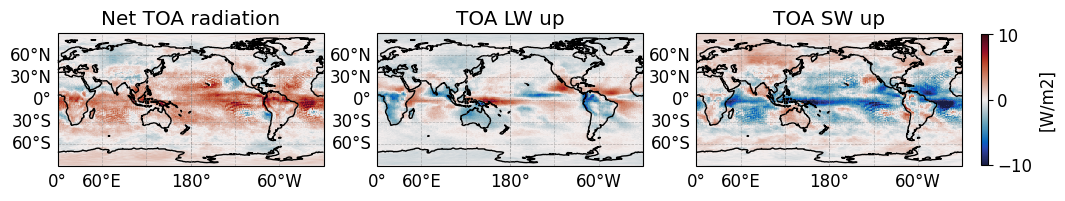

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axes = axes.flatten()
lons, lats = np.meshgrid(time_mean["lon"], time_mean["lat"])
i = 0
for patch in ["net_energy_flux_toa_into_atmosphere", "FLUT", "top_of_atmos_upward_shortwave_flux"]:
    data = time_mean[f"bias_map-{patch}"]
    cf = axes[i].pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=-10, vmax=10)
    axes[i].coastlines()
    axes[i].set_global()
    axes[i].set_title(titles[i])
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    i += 1
cbar = fig.colorbar(cf, ax=axes, orientation="vertical", pad=0.02, fraction=0.007)
cbar.set_label(f"[W/m2]")
fig.patch.set_alpha(0.0)

fig.savefig(
    "e3smv3-80levs/2025-04-22-ace-eamv3-beaker-RS2-amip-1970-2020-rad-map-cm-balance.png",
    dpi=200,  
    bbox_inches="tight",
)